# **Reinforcement Learning**

<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

<br>
<br>
<br>
<br>

<center><img src="https://media.tenor.com/zOoVaNGp6IsAAAAd/mario-game.gif"><center>

In [ ]:
!pip install autorom[accept-rom-license]
!pip install swig
# !pip install gym[atari]
# !pip install gym[box2d]
!pip install gymnasium[atari]
!pip install gymnasium[box2d]

In [2]:
import random
import math
import copy
from tqdm.auto import tqdm
from collections import defaultdict, deque, namedtuple
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML, clear_output
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit
import itertools

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import adamw
from torch.distributions import Normal


from torch.autograd import Variable

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_video(episode=0, video_width=600, video_dir= "./content/video"):
    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode="rgb_array", record=False, video_folder='./content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, render_mode=render_mode)
    # env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 50 == 0)
    if record:
        print('Recording video...!')
        env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
    env = RecordEpisodeStatistics(env)
    return env

## **Soft Actor Critic(SAC)**

Reference paper : [Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor](https://arxiv.org/abs/1801.01290)

<br>

- Standard RL maximizes the expected sum of rewards:

$$
\large \sum_t \mathbb{E}_{(s_t,a_t)\sim \rho_\pi}[r(s_t, a_t)]
$$

<br>

- consider maximum entropy objective:

$$
\large \sum_{t=0} \mathbb{E}_{(s_t,a_t)\sim \rho_\pi} \Bigl[r(s_t, a_t) + \alpha \mathcal{H}\bigl(\pi(\cdot|s_t) \bigr) \Bigr] \hspace{1cm} \mathcal{(1)}
$$

<br>

> $\alpha$: emperature parameter determines the relative importance of the entropy term against the reward**(controls the stochasticity)**.<br>
$ \mathcal{H}\bigl(\pi(\cdot|s_t)\bigr) = - \log \pi (a|s)$ is it???

With soft actor-critic algorithm we use a policy iteration,  we will evaluate the $Q$ value of the current policy, after that we can update the policy through an off-policy gradient update.

### **Policy Iteration**

For a ﬁxed policy, repeatedly applying a modiﬁed Bellman backup operator $\mathcal{T^\pi}$ we can calculate the $Q$ value:

$$
\large \mathcal{T^\pi} Q(s_t, a_t) \triangleq r(s_t, a_t) + \gamma \mathbb{E}_{s_{t+1}\sim \rho} \bigl[V_{s_{t+1}}\bigr] \hspace{1cm} \mathcal{(2)}
$$

<br>

where:
$$\large V(s_t) = \mathbb{E}_{a_t \sim \pi} \big[ Q(s_t, a_t) - \log \pi(a_t | s_t) \big] \hspace{1cm} \mathcal{(3)}
$$

<br>

> $\log \pi(a_t | s_t)$ This term introduces entropy regularization, acts as a regularization for the policy. It penalizes policies that are too deterministic

<br>

---
Suppose we have a random variable $x$ following some distribution $P(x)$. The entropy of the $x$ is defined as follows:
$$
H(P) = \mathbb{E}_{x \sim P} \big[- \log P(x)\big]
$$


Suppose we have a coin with $P(H) = \rho$ and $P(T) = 1 - \rho$. We calculate the entropy $H$ for different values of $ρ \in (0, 1)$.

So imagin we throw it

$$
H(P) =  -\big[\rho \log \rho + (1 - \rho)\log(1 - \rho) \big]
$$

$H$ is the maximum for $\rho = 0.5$,(we have maximum uncertainty between getting a 1 or a 0). Indeed, by maximizing the entropy we are ensuring that the stochastic action policy has a broad distribution and does not collapse to a sharp peak too early. A sharp peak will reduce the exploration.
- If $\pi(a_t \mid s_t)$ is very peaked (deterministic), the entropy  $-\log \pi(a_t \mid s_t)$  will be low, and the penalty will be small and the other way around.

---

<br>

In the policy improvement step, we update the policy towards the exponential of the new $Q$ value. we will restrict the policy to some set of policies $\Pi$ (such as Gaussians), To account for the constraint that $\pi ∈ \Pi$, we project the improved policy into the desired set of policies

<br>

$$
\large \pi_{\text{new}} = \arg \min_{\pi' \in \Pi} D_{\text{KL}} \Bigg( \pi'(\cdot \mid s_t) \,\|\, \frac{\mathcal{exp} \big(Q^{\pi_\text{old}}(s_t, \cdot)\big)}{Z^{\pi_{\text{old}}}(s_t)} \Bigg) \hspace{1cm} \mathcal{(4)}
$$

<br>

> $Z^{\pi_{\text{old}}}(s_t)$: The partition function normalizes the distribution

<br>

Instead of running evaluation and improvement to convergence, we will optimizing both networks with stochastic gradient descent.

We will consider a parameterized:
- state value function $V_ψ (s_t)$, can be modeled as expressive neural networks
- soft $Q$-function $Q_\theta (s_t , a_t)$
- a tractable policy $\pi_\phi (a_t | s_t )$. a Gaussian distribution with mean and covariance given by neural network

The parameters of these networks are $\psi$ ,$\theta$, and $\phi$.


> **Note:**There is no need in principle to include a separate network. This quantity can beestimated from a single action sample from the current policy without introducing a bias. In practice, however, a separate value network can stabilize training and is convenient to train simultaneously with the other networks.







### **Loss calculation**

 - ### *The value function is trained to minimize the squared residual error:*

$$
\begin{split}
\large J_V(\psi) & = \large \mathbb{E}_{s_t \sim \mathcal{D}} \Biggl[ \Bigl( V\psi(s_t) - \mathbb{E}_{a_t \sim \pi_\phi} \left[ Q_\theta(s_t, a_t) - \log \pi_\phi(a_t \mid s_t) \right] \Bigr)^2 \Biggr] \\
\\
\text{Gradient:}\\
\\
\large \nabla_\psi J_V(\psi) & = \large \nabla_\psi V_\psi(s_t) \cdot \left( V_\psi(s_t) - Q_\theta(s_t, a_t) + \log \pi_\phi(a_t \mid s_t) \right)
\end{split}
$$

<br>

> $\mathcal{D}$ is the distribution of previously sampled states and actions, or a replay buffer.<br>
Actions are sampled according to the current policy, instead of the replay buffer.

<br>

- ### *The Q-function parameters can be trained to minimize the soft Bellman residual*

$$
\begin{split}
\large J_Q(\theta) & = \large \mathbb{E}_{(s_t, a_t) \sim \mathcal{D}} \Biggl[\frac{1}{2} \biggl( Q(s_t, a_t) - \hat{Q}(s_t, a_t) \biggr)^2 \Biggr] \\
\\
\text{Gradient:}\\
\\
\large {\nabla_\theta} J_Q(\theta) & = \large \nabla_\theta Q_\theta(s_t, a_t) \cdot \left( Q_\theta(s_t, a_t) - r(s_t, a_t) - \gamma V_{\bar{\psi}}(s_{t+1}) \right)
\end{split}
$$

<br>

> $\hat{Q}(s_t, a_t) = r(s_t, a_t) + \gamma \, \mathbb{E}_{s_{t+1} \sim p} \left[ V_{\bar{\psi}}(s_{t+1}) \right]$, <br>
$V_{\bar{\psi}}(s_{t+1}) =  Q(s_t, a_t) - \alpha * \log \pi_\phi \left(a_t | s_t \right) $ <br>
$V_{\bar{\psi}}$ is target value network

<br>

- ### *the policy parameters can be learned by directly minimizing the expected KL-divergence*

$$
\large J_\pi(\phi) = \mathbb{E}_{s_t \sim \mathcal {D}} \Biggl[  D_{\text{KL}} \Bigg( \pi_{\phi}(\cdot \mid s_t) \,\|\, \frac{\mathcal{exp} \big(Q_{\theta}(s_t, \cdot)\big)}{Z_{\theta}(s_t)} \Bigg) \Biggr]
$$

<br>

There are several options for minimizing $J_\pi$:
1. if we can not backprogate we use the likelihood ratio gradient estimator
2. if so, it is convenient to apply the reparameterization trick instead, resulting in a lower variance estimator.

$$
\large a_t = f_\phi (\epsilon_t ; s_t)
$$

> $\epsilon_t$ is an input noise vector, sampled from some ﬁxed distribution,

<br>

$$
\large J_{\pi_\phi} = \mathbb{E}_{s_t \sim \mathcal{D}, \epsilon_t \sim \mathcal{N}} \left[ \log \pi_\phi \left( f_\phi(\epsilon_t; s_t) \mid s_t \right) - Q_\theta \left( s_t, f_\phi(\epsilon_t; s_t) \right) \right]
$$

<br>

> where $\pi_\phi$ is deﬁned implicitly in terms of $f_\phi$ , and we have noted that the partition function is independent of $\phi$ and can thus be omitted.

$$
\large \nabla_\phi J_\pi(\phi) = \nabla_\phi \log \pi_\phi(a_t | s_t) + \left( \nabla_{a_t} \log \pi_\phi(a_t | s_t) - \nabla_{a_t} Q(s_t, a_t) \right) \nabla_\phi f_\phi(\epsilon_t; s_t)
$$

<br>

> where $a_t$ is evaluated at $f_\phi(\epsilon_t; s_t)$.









In [4]:
class ReplayBuffer():
    """
    A fixed-size buffer that stores agent experiences for replay.

    Attributes:
        capacity (int): Maximum number of experiences the buffer can hold.
        buffer (list): A fixed-size list to store experiences.
        idx (int): The index where the next experience will be stored in the buffer.
        full (bool): Whether the buffer has reached its maximum capacity.
    """
    def __init__(self, capacity):
        """
        Initialize the ReplayBuffer.

        Args:
            capacity (int): The maximum number of experiences to store in the buffer.
        """
        self.capacity = capacity  # Maximum size of the buffer
        self.buffer = [None] * self.capacity  # Fixed array to avoid resizing
        self.idx = 0  # Pointer to the next insertion index
        self.full = False  # Flag to check if the buffer is full

    def __len__(self):
        """
        Return the current number of experiences stored in the buffer.

        Returns:
            int: Number of elements in the buffer.
        """
        return self.capacity if self.full else self.idx

    def append(self, experience):
        """
        Add a new experience to the buffer.

        If the buffer is full, the oldest experience is overwritten.

        Args:
            experience (tuple): A single experience (state, action, reward, next_state, done).
        """
        self.buffer[self.idx] = experience
        self.idx = (self.idx + 1) % self.capacity  # Circular buffer logic
        if self.idx == 0:  # If pointer wraps back to 0, buffer is full
            self.full = True

    def sample(self, batch_size):
        """
        Sample a random batch of experiences from the buffer.

        Args:
            batch_size (int): The number of experiences to sample.

        Returns:
            list: A list of randomly sampled experiences from the buffer.
        """
        max_size = self.capacity if self.full else self.idx
        indices = random.sample(range(max_size), batch_size)
        samples = [self.buffer[i] for i in indices]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)


    def __getitem__(self, index):
        """
        Retrieve one or more experiences from the buffer by index or slice.

        Args:
            index (int or slice): The index or slice of the desired experience(s).

        Returns:
            tuple or list: The experience(s) at the given index or slice.
        """
        if isinstance(index, slice):
            # Handle slicing
            return [self.buffer[i % self.capacity] for i in range(*index.indices(len(self)))]
        elif isinstance(index, int):
            # Handle indexing
            if index < 0:  # Support negative indexing
                index += len(self)
            if index >= len(self) or index < 0:
                raise IndexError("Index out of range")
            return self.buffer[index % self.capacity]
        else:
            raise TypeError("Index must be an int or slice")

In [5]:
class PolicyNetwork(nn.Module):
    """
    A neural network that represents the policy (actor) in DDPG.
    This network maps states to actions in continuous action spaces.
    """

    def __init__(self, n_state, action_dim, action_interval, n_hidden=64):
        """
        Initialize the policy network.

        Args:
            n_state (int): Dimension of the state space.
            action_dim (int): Dimension of the action space (number of action variables).
            action_interval (float): The maximum absolute value for actions (action range: [-action_interval, action_interval]).
            epsilon (float): Standard deviation of exploration noise added to actions for exploration.
            n_hidden (int): Number of hidden units in each layer.
        """
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_interval = action_interval
        self.log_sigma_max = 2
        self.log_sigma_min = -20
        self.head = nn.Sequential(
            nn.Linear(n_state, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU()
        )
        self.mu = nn.Linear(n_hidden, action_dim)
        self.log_sigma = nn.Linear(n_hidden, action_dim)

        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        This initialization is particularly effective with ReLU activations.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state):
        """
        Forward pass to compute the action.

        Args:
            state (torch.Tensor): The input state tensor of shape (batch_size, n_state).

        Returns:
            torch.Tensor: The action tensor of shape (batch_size, action_dim) with noise added for exploration.
        """
        head = self.head(state)
        mu = self.mu(head)
        log_sigma = self.log_sigma(head)
        log_sigma = torch.clamp(log_sigma, self.log_sigma_min, self.log_sigma_max)
        sigma = torch.exp(log_sigma)
        return mu , sigma


class Q_Network(nn.Module):
    """
    A neural network that represents the Q-function (critic) in DDPG.
    This network estimates the Q-value for given state-action pairs.
    """

    def __init__(self, n_state, action_dim, n_hidden=64):
        """
        Initialize the Q-network.

        Args:
            n_state (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            n_hidden (int): Number of hidden units in each layer.
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_state + action_dim, n_hidden * 2),
            nn.ReLU(),
            nn.Linear(n_hidden * 2, n_hidden * 4),
            nn.ReLU(),
            nn.Linear(n_hidden * 4, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)  # Output a single Q-value
        )

        # Initialize the weights of the network
        self.initialize_weights()

    def initialize_weights(self):
        """
        Initializes the weights of the network using Kaiming normal initialization.
        This initialization is particularly effective with ReLU activations.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, state, action):
        """
        Forward pass to compute the Q-value for a given state-action pair.

        Args:
            state (torch.Tensor): The input state tensor of shape (batch_size, n_state).
            action (torch.Tensor): The input action tensor of shape (batch_size, action_dim).

        Returns:
            torch.Tensor: The estimated Q-value tensor of shape (batch_size,).
        """
        # Concatenate state and action as input
        input = torch.cat([state, action], dim=-1)

        # Compute the Q-value
        return self.model(input).squeeze(-1)

In [6]:
from torch.distributions import Normal, TransformedDistribution, TanhTransform
class Policy():
    """
    Deep Q-Network (DQN) implementation.
    """
    def __init__(self, env, n_hidden=64, lr=0.05, optStep=0.9):
        """
        Initialize the DQN agent.

        Args:
            env: OpenAI Gym environment.
            n_hidden (int): Number of hidden units in the neural network.
            lr (float): Learning rate for the optimizer.
            optStep (float): Step size factor for learning rate scheduler.
        """
        self.action_dim = env.action_space.shape[0] # Number of possible actions
        self.n_state = env.observation_space.shape[0] # Dimension of state space
        self.action_interval = env.action_space.high[0] # Action bounds
        self.step = 0
        self.p_loss = 0
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.target_entropy = - self.action_dim
        self.log_alpha = torch.tensor(0.0, requires_grad=True, device=self.device)
        self.alpha = self.log_alpha.exp().item()

        # Policy and Q networks
        self.policy_model = PolicyNetwork(self.n_state, self.action_dim, self.action_interval, n_hidden).to(self.device)
        self.policy_model_target = copy.deepcopy(self.policy_model)

        self.Q1_model = Q_Network(self.n_state, self.action_dim, n_hidden).to(self.device)
        self.Q1_model_target = copy.deepcopy(self.Q1_model)

        self.Q2_model = Q_Network(self.n_state, self.action_dim, n_hidden).to(self.device)
        self.Q2_model_target = copy.deepcopy(self.Q2_model)


        # Set up the optimizer and learning rate scheduler
        self.policy_optimizer = torch.optim.Adam(self.policy_model.parameters(), lr*0.3)
        self.policy_schedul = torch.optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=50, gamma=optStep)

        self.Q_Network_params = itertools.chain(self.Q1_model.parameters(), self.Q2_model.parameters())
        self.Q_optimizer = torch.optim.Adam(self.Q_Network_params, lr)
        self.Q_schedul = torch.optim.lr_scheduler.StepLR(self.Q_optimizer, step_size=50, gamma=optStep)

        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr)
        self.alpha_schedul = torch.optim.lr_scheduler.StepLR(self.alpha_optimizer, step_size=50, gamma=optStep)


    def update_alpha(self, actions_logp):
        # Compute the alpha loss
        alpha_loss = -(self.log_alpha * (actions_logp + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # Update alpha dynamically
        alpha = self.log_alpha.exp()
        return alpha, alpha_loss


    def update_target_network(self, tau=0.99):
        """
        Update the target Q-network using Polyak averaging.

        Args:
            tau (float): Weighting factor for the update (default: 0.01).
        """
        for params, target_params in zip(self.Q1_model.parameters(), self.Q1_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

        for params, target_params in zip(self.Q2_model.parameters(), self.Q2_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)

        for params, target_params in zip(self.policy_model.parameters(), self.policy_model_target.parameters()):
            target_params.data.copy_(tau * target_params.data + (1 - tau) * params.data)


    def get_action(self, states, target=False):
        """
        Get the action, log probability, and deterministic policy output for given states.

        Args:
            states (torch.Tensor): The input state tensor.
            target (bool): If True, use the target policy network; otherwise, use the main policy network.

        Returns:
            tuple: (action, log_prob, deterministic_action)
                action (torch.Tensor): Sampled action.
                log_prob (torch.Tensor): Log probability of the action.
                deterministic_action (torch.Tensor): Deterministic action (mean of the policy).
        """

        if target:
            with torch.no_grad():
                mu, sigma = self.policy_model_target(states)
        else:
            mu, sigma = self.policy_model(states)

        # Pre-squash distribution and sample
        # This represents the stochastic policy’s action distribution before squashing
        pi_distribution = Normal(mu, sigma)   # 𝜋(𝑎|𝑠) = N(𝜇,𝜎)
        # samples an action from the distribution using reparameterization trick,
        x_t = pi_distribution.rsample()     # 𝑥 ~ 𝜋(𝑎|𝑠))
        # apply Tanh() to action in order to be in [-1, 1]
        y_t = torch.tanh(x_t)
        pi_action = y_t  * self.action_interval

        # Compute the Log Probability of the Sampled Action
        # Computes the log probability of the sampled pre-squashed action x_t under the Gaussian distribution
        log_prob = pi_distribution.log_prob(x_t)    # log(𝜋(𝑥|𝑠)) = − (1 / 2)( [(𝑥−𝜇)^2 / 𝜎^2] + 2log𝜎 + log(2𝜋) )
        # Enforcing Action Bound
        # The Tanh transformation changes the volume of the probability space, and this correction term adjusts
        #       the log-probability accordingly. The volume change is quantified by the derivative of the Tanh function:
        #       𝑑/𝑑𝑥 tanh(𝑥) = 1 − (tanh(𝑥))^2

        # we divide the probability density by the absolute value of this derivative to correctly transform
        #       the probability density after the Tanh operation: (x_t) / [action_interval * (1 − (tanh(𝑥))^2) + ε]
        #       Since it is log we subtracted it
        log_prob -= torch.log(self.action_interval * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(-1, keepdim=True)

        # deterministic version of the policy’s output
        deterministic_action = torch.tanh(mu) * self.action_interval
        return pi_action, log_prob, deterministic_action


    def Q_net_loss(self, states, actions, rewards, next_states, dones, gamma=0.99, alpha=0.2, mode = 'MSE'):
        """
        Compute the Q-network loss.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken.
            rewards (torch.Tensor): Rewards received.
            next_states (torch.Tensor): Next states.
            dones (torch.Tensor): Done flags.
            gamma (float): Discount factor.
            mode (str): Loss type ('MSE' or 'Huber').

        Returns:
            torch.Tensor: Q-network loss.
        """
        # rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        Q1 = self.Q1_model(states, actions)
        Q2 = self.Q2_model(states, actions)
        with torch.no_grad():
            action_target, action_target_logp, _ = self.get_action(next_states, target=True)
            Q1_next = self.Q1_model_target(next_states, action_target)
            Q2_next = self.Q2_model_target(next_states, action_target)
            target_Q = torch.min(Q1_next, Q2_next) - alpha * action_target_logp
            target = rewards + gamma * (1 - dones) * target_Q

        if mode == 'MSE':
            Q1_loss = nn.functional.mse_loss(Q1, target)
            Q2_loss = nn.functional.mse_loss(Q2, target)
            return (Q1_loss + Q2_loss) / 2 # Combined loss
        else:
            Q1_loss = nn.functional.smooth_l1_loss(Q1, target)  # Huber loss
            Q2_loss = nn.functional.smooth_l1_loss(Q2, target)  # Huber loss
            return (Q1_loss + Q2_loss) / 2 # Combined loss



    def policy_loss(self, states, alpha=0.2):
        """
        Compute the policy loss.

        Args:
            states (torch.Tensor): Current states.

        Returns:
            torch.Tensor: Policy loss.
        """
        actions, actions_logp, _ = self.get_action(states)
        Q1 = self.Q1_model(states, actions)
        Q2 = self.Q2_model(states, actions)
        Q = torch.min(Q1, Q2)
        return - (Q - alpha * actions_logp).mean()


    def update(self, states, actions, rewards, next_states, dones, gamma):
        """
        Update the policy and Q-network.

        Args:
            states (torch.Tensor): Current states.
            actions (torch.Tensor): Actions taken.
            rewards (torch.Tensor): Rewards received.
            next_states (torch.Tensor): Next states.
            dones (torch.Tensor): Done flags.
            gamma (float): Discount factor.
        """
        self.step += 1

        # Update Q-network
        Q_loss = self.Q_net_loss(states, actions, rewards, next_states, dones, gamma, self.alpha)
        self.Q_optimizer.zero_grad()
        Q_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.Q_Network_params, max_norm=0.5)  # Gradient clipping
        self.Q_optimizer.step()

        if self.step % 2 == 0:
            # Freeze Q-network
            for params in self.Q_Network_params:
                params.requires_grad = False

            # Backpropagate and update the policy model
            p_loss = self.policy_loss(states, self.alpha)
            self.policy_optimizer.zero_grad()
            p_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), max_norm=0.5)  # Gradient clipping
            self.policy_optimizer.step()
            self.p_loss = p_loss
            # Unfreeze Q-network
            for params in self.Q_Network_params:
                params.requires_grad = True

            with torch.no_grad():
                _, actions_logp, _ = self.get_action(states)

            self.alpha, _ = self.update_alpha(actions_logp)

            self.update_target_network()

        return Q_loss, self.p_loss


In [7]:
class SAC():
    def __init__(self, env, network, gamma=0.99, n_episode=1000, batch_size=256,
                 train_step=20, explore_steps=10_000, log_on_fly=True):
        # Initialize the class with essential hyperparameters and environment details

        self.device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

        # Environment and agent parameters
        self.env = env  # Gym environment
        self.network = network  # Policy and Q-network (actor-critic)
        self.gamma = gamma  # Discount factor for rewards
        self.n_episode = n_episode  # Total number of training episodes
        self.epi = 0  # Current episode index
        self.buffer = ReplayBuffer(10 * explore_steps)  # Replay buffer to store experiences
        self.batch_size = batch_size  # Batch size for training
        self.explore_steps = explore_steps  # Number of steps for initial exploration
        self.train_step = train_step  # Number of training updates per episode

        # Metrics to track training progress
        self.length_episode = []  # Stores episode lengths
        self.total_reward_episode = []  # Stores total rewards for each episode
        self.Q_losses = []  # Stores Q-network losses
        self.policy_losses = []  # Stores policy network losses
        self.log_on_fly = log_on_fly  # Whether to log progress during training

        # Ensure the replay buffer is filled with enough samples before training starts
        while len(self.buffer) < explore_steps:
            print(f"{len(self.buffer)} sample(s) in buffer, filling...")
            self.play()

    def sample(self, index=False):
        # Sample a batch of experiences from the replay buffer
        sample_size = min(len(self.buffer), self.batch_size)
        states, actions, rewards, next_states, dones = self.buffer.sample(sample_size)

        # Convert states and actions to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones.astype('float32')).to(self.device)

        return states, actions, rewards, next_states, dones

    def test_agent(self, env, agent, num_test_episodes):
        # Evaluate the agent's performance over a specified number of test episodes
        ep_rets, ep_lens = [], []  # Episode returns and lengths
        for j in range(num_test_episodes):
            state, _ = env.reset()  # Reset the environment
            state = torch.tensor(state, dtype=torch.float32).to(self.device)
            done, rewards, length = False, 0, 0
            while not done:
                # Take deterministic actions during testing
                with torch.no_grad():
                    action = agent.get_action(state)[2].detach().cpu().numpy()
                state, reward, done, _ = env.step(action)
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                rewards += reward
                length += 1
            ep_rets.append(rewards)  # Record the total reward
            ep_lens.append(length)  # Record the episode length
        return np.mean(ep_rets), np.mean(ep_lens)  # Return average reward and length

    def train(self):
        """
        Train the agent using the DDP algorithm.
        """
        print(f"Available device: {self.device} - Highest possible score: {self.env.spec.reward_threshold}")
        pbar = tqdm(range(self.n_episode))  # Progress bar for training episodes

        for episode in pbar:
            # Play one episode and collect trajectory data
            self.play(train=True)

            # Perform multiple training updates
            q_loss, p_loss = 0, 0
            for _ in range(self.train_step):
                # Sample a batch of experiences
                states, actions, rewards, next_states, dones = self.sample()
                # Update the policy and Q-networks
                q_l, p_l = self.network.update(states, actions, rewards, next_states, dones, self.gamma)
                q_loss += (q_l / self.train_step)  # Average Q-loss
                p_loss += (p_l / self.train_step)  # Average policy loss
            self.Q_losses.append(q_loss.detach().cpu().numpy())  # Record Q-loss
            self.policy_losses.append(p_loss.detach().cpu().numpy())  # Record policy loss

            # Update the progress bar with learning rate and recent average rewards
            avg_reward = np.mean(self.total_reward_episode[max(0, episode - 50):episode + 1])
            pbar.set_description(f"α Policy network: {round(self.network.policy_optimizer.param_groups[0]['lr'], 6)} |"
                                 f" α Q network: {round(self.network.Q_optimizer.param_groups[0]['lr'], 6)} |"
                                 f" Avg Reward: {avg_reward:.2f} |")

    def play(self, train=False):
        """
        Play one episode of the environment.

        Args:
            train (bool): If True, track episode statistics and update the learning schedule.
        """
        state, _ = self.env.reset()  # Reset the environment
        length_episode = 0  # Track the episode length
        total_reward_episode = 0  # Track total rewards for the episode
        done = False

        while not done:
            # Choose action based on exploration or policy
            if train:
                with torch.no_grad():
                    action = self.network.get_action(torch.tensor(state, device=self.device))[0].detach().cpu().numpy()
            else:
                action = self.env.action_space.sample()  # Random action for exploration

            # Perform action and observe the environment's response
            next_state, reward, done, _ = self.env.step(action)

            # Update episode statistics during training
            if train:
                length_episode += 1
                total_reward_episode += reward

            # Store the transition in the replay buffer
            self.buffer.append((state, action, reward, next_state, done))

            state = next_state  # Move to the next state

        # Track episode metrics during training
        if train:
            self.epi += 1
            self.length_episode.append(length_episode)
            self.total_reward_episode.append(total_reward_episode)
            self.network.policy_schedul.step()  # Update policy learning rate
            self.network.Q_schedul.step()  # Update Q-learning rate
            self.network.alpha_schedul.step()
            if self.log_on_fly and (self.epi % 3 == 0):
                self.log()

    def log(self):
        """
        Log training statistics and plot metrics.
        """
        if self.log_on_fly:
            clear_output(True)

        fig = plt.figure(figsize=(16, 4))

        # Plot total reward per episode
        fig.add_subplot(1, 4, 1)
        plt.plot(self.total_reward_episode)
        plt.title('Episode reward over time')
        plt.xlabel('Episode')
        plt.ylabel('Total reward')

        # Plot episode length over time
        fig.add_subplot(1, 4, 2)
        plt.plot(self.length_episode)
        plt.title('Episode length over time')
        plt.xlabel('Episode')
        plt.ylabel('Length')

        # Plot Q-loss over episodes
        fig.add_subplot(1, 4, 3)
        plt.plot(self.Q_losses)
        plt.title('Q_loss over time')
        plt.xlabel('Episode')
        plt.ylabel('Q_loss')

        # Plot policy loss over episodes
        fig.add_subplot(1, 4, 4)
        plt.plot(self.policy_losses)
        plt.title('Policy loss over time')
        plt.xlabel('Episode')
        plt.ylabel('Policy loss')

        # Display current training progress
        if self.log_on_fly:
            avg_reward = np.mean(self.total_reward_episode[max(0, self.epi - 50):self.epi + 1])
            fig.suptitle(f"Episode: {self.epi+1} |"
                        f"α Policy network: {round(self.network.policy_optimizer.param_groups[0]['lr'], 6)} |"
                        f" α Q network: {round(self.network.Q_optimizer.param_groups[0]['lr'], 6)} |"
                        f" Avg Reward: {avg_reward:.2f} |")
        plt.show()

In [ ]:
env = create_env('LunarLanderContinuous-v3', render_mode='rgb_array', record=False)
n_hidden = 64
lr = 0.001
net = Policy(env, n_hidden=n_hidden, lr=lr, optStep=0.99)

gamma = 0.99
n_episode = 1000
batch_size = 256
train_step = 20
explore_steps=10_000
agent = SAC(env, net, gamma, n_episode, batch_size, train_step, explore_steps, log_on_fly=False)

Available device: cpu - Highest possible score: 200


  0%|          | 0/1000 [00:00<?, ?it/s]

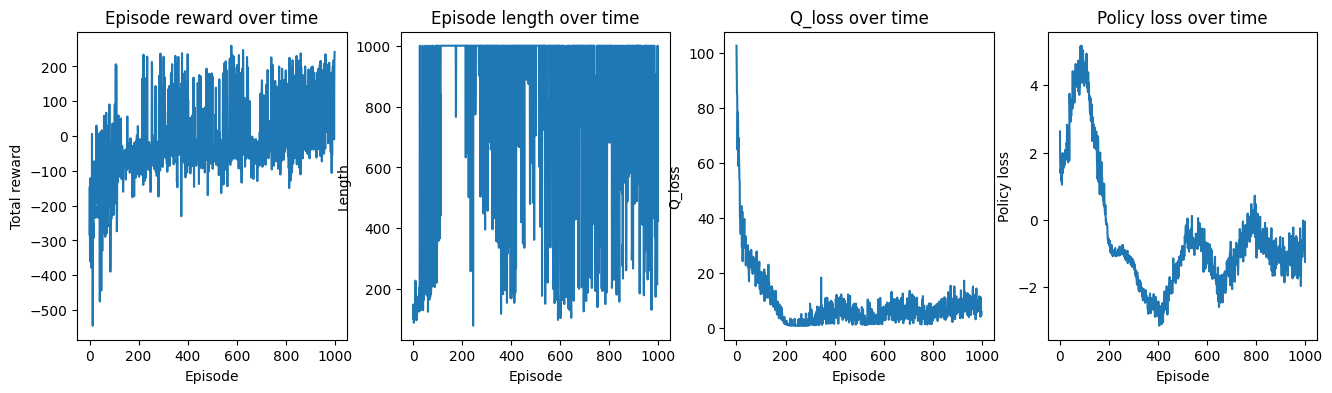

In [ ]:
agent.train()
agent.log()

In [ ]:
# play three episode and record playing
env = create_env('LunarLanderContinuous-v3', render_mode='rgb_array', record=True)
reward, length = agent.test_agent(env, agent.network, 3)
print("Mean reward over 3 episodes: ", reward)

Recording video...!
Mean reward over 3 episodes:  87.37716208502934


In [ ]:
# save actor and critic
torch.save(net.policy_model.state_dict(), './content/Policy')
torch.save(net.Q_model.state_dict(), './content/Q')

# Load actor and critic
net.policy_model.load_state_dict(torch.load('./content/Policy', weights_only=True))
net.Q_model.load_state_dict(torch.load('./content/Q', weights_only=True))